# 2024-02-01 Dataset Cleaning

**Goal**: For each animal's scraped data from data.mat files, clean up the data to be ready for modeling.

Specifically, map column names and formats to things already used by the design_matrix_generator classes such that all code previously written for modeling is easy to adapt. Also, account for timeout trials (referred to as "trials not started") and drop them from the dataset. 

Related notebooks
* `2024_01_23_dev_new_dataset_cleaning.ipynb`

In [1]:
from multiglm.data import ANIMAL_IDS, COLUMN_RENAME
from multiglm.data.dataset_cleaner import clean_datasets

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2

In [2]:
print(ANIMAL_IDS)

['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


Run cleaning code below & save out cleaned df- located at `../data/cleaned/all_animals_cleaned.csv`. Will be in gitignore due to large file size.

In [32]:
# all_animals_df = clean_datasets(ANIMAL_IDS, COLUMN_RENAME, save_out=True)

** RUNNING W051 **
** RUNNING W060 **
** RUNNING W065 **
** RUNNING W066 **
** RUNNING W068 **
** RUNNING W072 **
** RUNNING W073 **
** RUNNING W074 **
** RUNNING W075 **
** RUNNING W078 **
** RUNNING W080 **
** RUNNING W081 **
** RUNNING W082 **
** RUNNING W083 **
** RUNNING W088 **
** RUNNING W089 **
** RUNNING W094 **


In [6]:
all_animals_df = pd.read_csv("../data/cleaned/all_animals_cleaned.csv")

### Column Check

In [7]:
all_animals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034200 entries, 0 to 3034199
Data columns (total 34 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   animal_id                 object 
 1   session_date              object 
 2   session_file_counter      int64  
 3   rig_id                    int64  
 4   training_stage            int64  
 5   s_a                       float64
 6   s_b                       float64
 7   hit                       float64
 8   violation                 int64  
 9   trial_not_started         bool   
 10  s_a_sigma                 float64
 11  rule                      object 
 12  correct_side              int64  
 13  violation_penalty_time    int64  
 14  error_penalty_time        int64  
 15  delayed_reward_time       float64
 16  pre_stim_time             float64
 17  s_a_time                  float64
 18  delay_time                float64
 19  s_b_time                  float64
 20  post_s_b_to_go_cue_time 

All the columns look good and have correct type matching. Lets look at the number of sessions.





In [34]:
all_animals_df.query("training_stage > 3").groupby("animal_id").session.nunique()

animal_id
W051    548
W060    437
W065    420
W066    602
W068    643
W072    497
W073    618
W074    606
W075    627
W078    300
W080    417
W081    533
W082    641
W083    688
W088    503
W089    520
W094    450
Name: session, dtype: int64



### Timeout / trial not started


These trials occurred when the `wait_for_cpoke` state tupped after a specified wait time. In most protocols, this wouldn't be counted as a trial. See the notebook `2024_01_22_explore_w078_dataset_remake.ipynb` that discovers these trials and the [SMA](https://github.com/Brody-Lab/Protocols/blob/master/%40AthenaDelayComp/AthenaSMA.m#L155) which produces it (and is summarized in the photo below). 

<div style="text-align: center;">
    <img src="/Users/jessbreda/Desktop/github/animal-learning/figures/pwm_timeouts_flow_chart.png" alt="pwm_timeout_flow_chart.png" width="600"/>
</div>


This wait time has been encoded in the cleaned df as `trial_start_wait_time`. Here, I want to check what the timer is for each animal.

In [35]:
all_animals_df.groupby("animal_id").trial_start_wait_time.value_counts()

animal_id  trial_start_wait_time
W051       200                      193053
W060       200                      148964
W065       200                      102602
W066       200                      171079
W068       200                      189859
W072       200                      113325
W073       200                      180136
W074       200                      267349
W075       200                      276179
W078       200                      105740
W080       200                       94611
W081       200                      136679
W082       200                      322230
W083       200                      277357
W088       200                      142400
W089       200                      180221
W094       200                      132416
Name: count, dtype: int64

It appears that all animals have a trial start wait time of 200 second. This means if 200 seconds elapsed and the animal did not start the trial with a cpoke, the trial would clean up and start a new one. I decided to drop these trials from the data frame (since they aren't really "trials"), but keep the history of them. Specifically, I added a feature called `n_prev_trial_not_started`. For every started/non-timeout trial, this feature documents how many contiguous previous trials were not started.  

Lets look at the distribution of this feature.

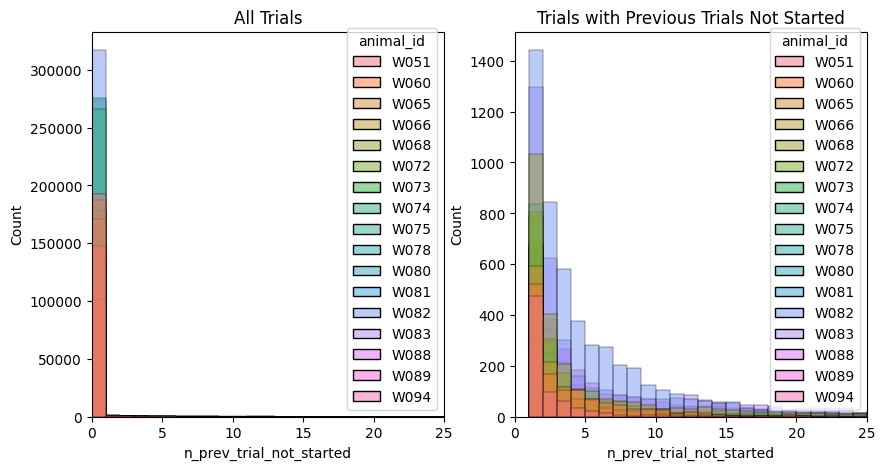

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    all_animals_df,
    x="n_prev_trial_not_started",
    hue="animal_id",
    binwidth=1,
    ax=ax[0],
)
_ = ax[0].set(title="All Trials", xlim=(0, 25))
sns.histplot(
    all_animals_df.query("n_prev_trial_not_started > 0"),
    x="n_prev_trial_not_started",
    hue="animal_id",
    binwidth=1,
    ax=ax[1],
)
_ = ax[1].set(title="Trials with Previous Trials Not Started", xlim=(0, 25))

The plot on the left demonstrates that the **vast** majority of the time, the current trial is not following a timeout trial (`n_prev_trial_not_started = 0`). 

The plot on the right is the data with the 0 values filtered out to assess the underlying distribution (note the change in y-axes). This distribution exponentially decays from 0 and appears to have a similar shape for all animals with some variations in magnitude. This could be an interesting regressor to include in the data.




### Choice Encoding

Next, I want to assess the choice encoding in the dataset. This is the choice made *by* the animal and will be what we are predicting in our models. Here the mapping is as follows: 

`Left : 0, Right : 1, Violation : 2`.

array([[<Axes: title={'center': 'choice'}>]], dtype=object)

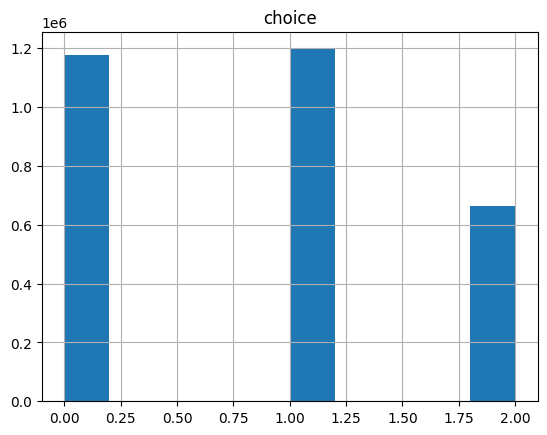

In [37]:
all_animals_df.hist(column="choice")

Good- this looks correct. L and R should be roughly equal and violations occur at a lower frequency. Let's explore violation rates a bit more.

In [38]:
all_animals_df.groupby("animal_id").violation.mean()

animal_id
W051    0.135471
W060    0.135429
W065    0.257003
W066    0.239340
W068    0.185259
W072    0.177719
W073    0.144319
W074    0.106602
W075    0.172653
W078    0.136817
W080    0.176407
W081    0.213990
W082    0.488400
W083    0.333761
W088    0.188132
W089    0.122849
W094    0.238030
Name: violation, dtype: float64

In [39]:
session_avg_viol_rate = (
    all_animals_df.groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .violation.mean()
)

session_avg_hit_rate = (
    all_animals_df.groupby(["animal_id", "session"]).hit.mean().reset_index().hit.mean()
)

print(f"Average violation rate per session: {session_avg_viol_rate:.2f}")
print(f"Average hit rate per session: {session_avg_hit_rate:.2f}")

Average violation rate per session: 0.23
Average hit rate per session: 0.77


These numbers appear correct given the alignment data figures. Also note, this is all training stages and not just the final stage with trained animals so these numbers will likely change once thresholding is applied.

Last, I want to assess the session counters. When I scraped the data, I often did not get the exact same amount of sessions per animal. Using an alignment procedure (using the max number of trials in the first 50 sessions) I attempted to align the old and new data frames. I want to see how staggered the two datasets are by looking the `session_relative_to_old` feature. 

The minimum value of this feature is the session in the old data frame in which the new data relates to (assuming alignment is correct). If this value is postive, this means the old dataset started earlier and vice versa.

In [40]:
all_animals_df.groupby("animal_id").session_relative_to_old.min()

animal_id
W051     1.0
W060     9.0
W065     5.0
W066     1.0
W068     8.0
W072     2.0
W073     2.0
W074     1.0
W075    15.0
W078    15.0
W080     5.0
W081     2.0
W082     2.0
W083     2.0
W088     1.0
W089     1.0
W094   -62.0
Name: session_relative_to_old, dtype: float64

It appears that the alignment was on the order of 1 to 15 sessions for most animals except for `W094`. When looking at the alignment data for this animal though, it does appear to not be correct (see `../figures/dataset_alignment/W094_alignment_mega_fig.png`) and if done properly, would be a similar magnitude to the others.